In [7]:
%pip install pydicom
%pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/3.3 MB ? eta -:--:--
   ---------------------- ----------------- 1.8/3.3 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 3.3/3.3 MB 12.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
#import pydicom as dicom
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import glob
from tensorflow.keras import layers, models

In [14]:
path = "../../Data/Temp/ADNI_136_S_1227_MR_MPR____N3__Scaled_Br_20070810000731580_S26837_I66824.nii"    
img = nib.load(path).get_fdata()
img.shape

(256, 256, 170)

In [ ]:
nii_files = glob.glob("../../Data/Temp/ADNI/**/*.nii", recursive=True)

images = []
for nii_file in nii_files:
    img_ = nib.load(nii_file).get_fdata()
    images.append(img_)

print(f"{len(images)} scans with shape {images[0].shape}")

25 scans with shape (256, 256, 170)


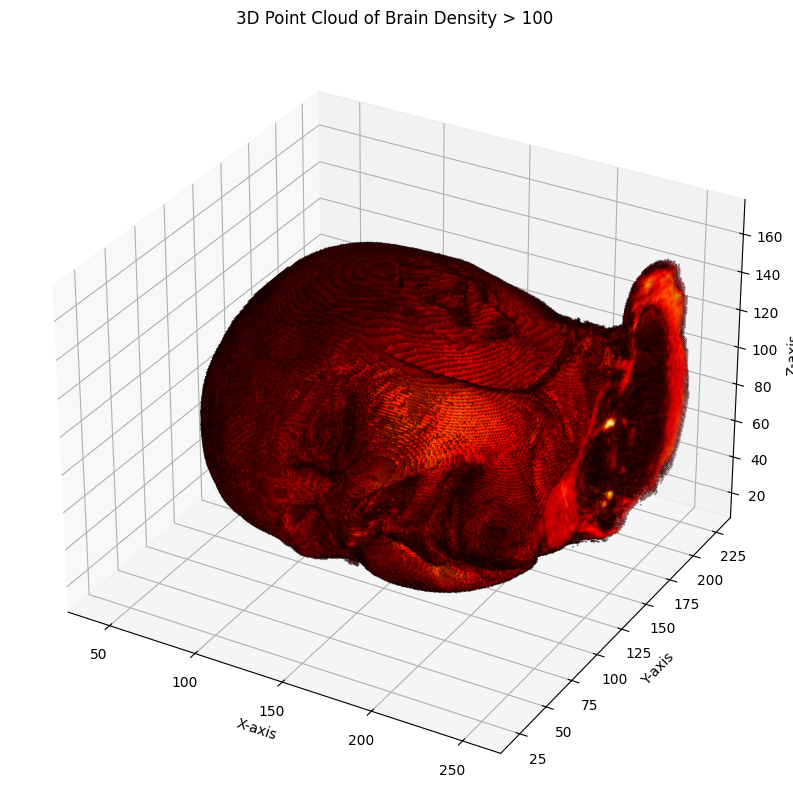

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
threshold = 100
indices = np.argwhere(img > threshold)

# Create the 3D point cloud plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(indices[:, 0], indices[:, 1], indices[:, 2], c=img[img > threshold], cmap='hot', s=0.1)

# Setting the labels and title
ax.set_title("3D Point Cloud of Brain Density > 100")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()

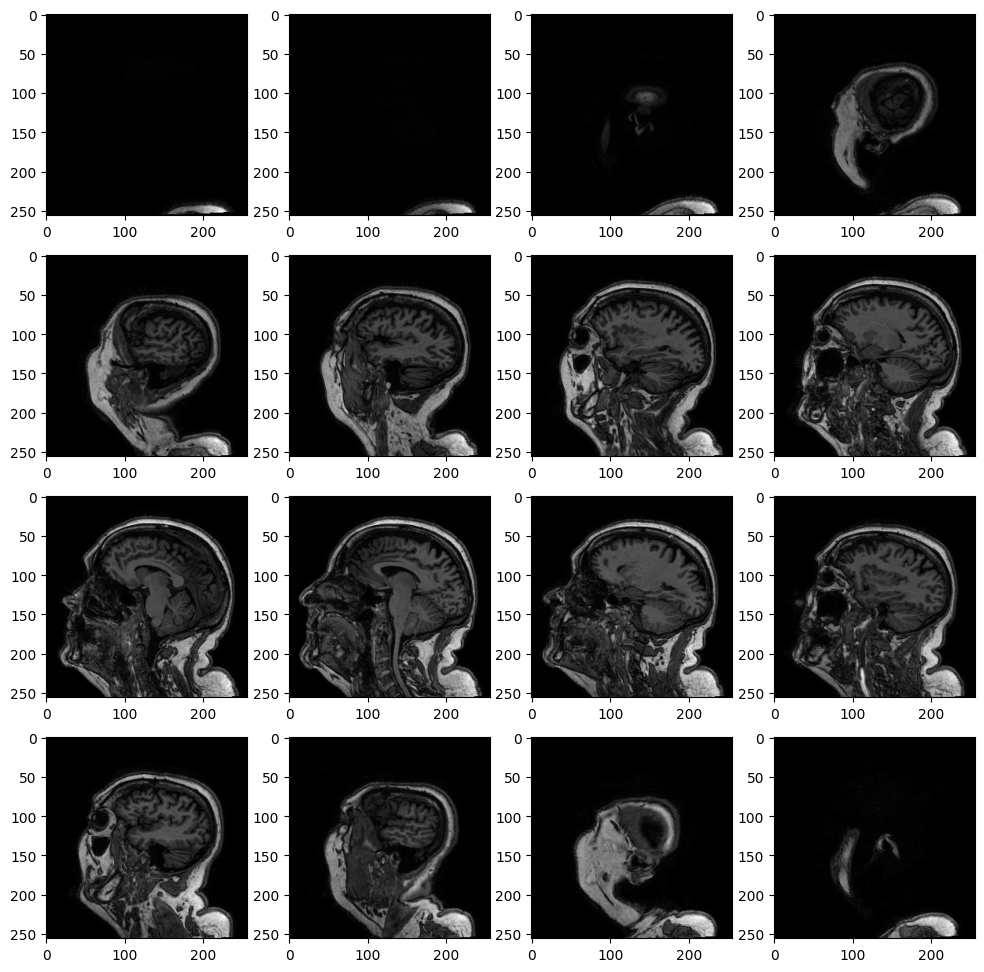

In [20]:
fig, axes = plt.subplots(4,4, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[1][:,:,i*10], cmap='gray')
plt.show()

79 217 33 140
82.72367559468383 152.09317165250212


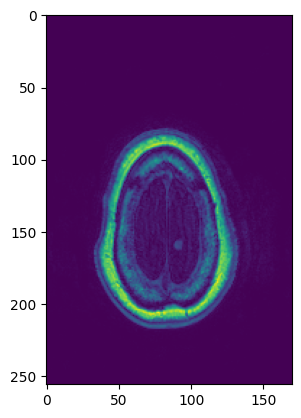

In [500]:
# Adjust brain position
# Locate centerpoint in XZ
image = images[0]
slice = image[60,:,:]
plt.imshow(image[60,:,:])
for zmin in range(0, slice.shape[0]):
    if any(slice[zmin,:] > 50): break
for zmax in range(slice.shape[0]-1,0,-1):
    if any(slice[zmax,:] > 50): break
for xmin in range(0, slice.shape[1]):
    if any(slice[:,xmin] > 50): break
for xmax in range(slice.shape[1]-1,0,-1):
    if any(slice[:,xmax] > 50): break
print(zmin,zmax,xmin,xmax)

x=np.arange(slice.shape[1])
z=np.arange(slice.shape[0])
xbar=np.sum(x*slice)/np.sum(slice)
zbar=np.sum(z*slice.T)/np.sum(slice)
print(xbar,zbar)

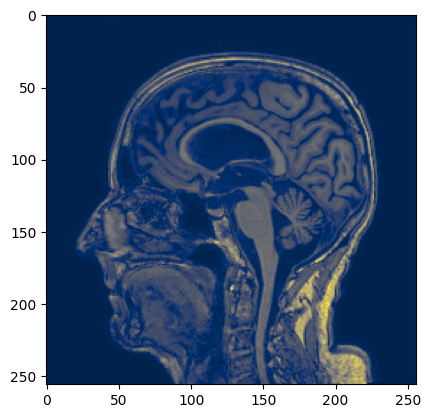

In [267]:

def check_and_correct_rotation(img):
    """
    Check the brightness along edges and rotate the image if necessary.
    :param img: 3D numpy array (image data)
    :return: Corrected image
    """
    # Calculate mean brightness along edges
    bottom_edge_brightness = np.mean(img[-1, :, :])  # Bottom edge along z-axis
    right_edge_brightness = np.mean(img[:, -1, :])  # Right edge along y-axis
    
    # Determine if rotation is needed
    if right_edge_brightness > bottom_edge_brightness:
        print("Rotating image 180 degrees about the xy-diagonal.")
        # Rotate about the xy-diagonal
        img = np.transpose(img, axes=(1, 0, 2))  # Swap x and y axes
        img = img[:, :, ::-1]  # Reverse the swapped axis
    return img

plt.imshow(check_and_correct_rotation(images[3])[:,:,85], cmap='cividis')
#plt.imshow(transform_image(images[3],[40,0,0,0,0,-0.3,1])[:,:,85], cmap='gray')

In [470]:
np.save("../../Data/Temp/test.npy",np.array(images[0]/900*255).astype("uint8"))

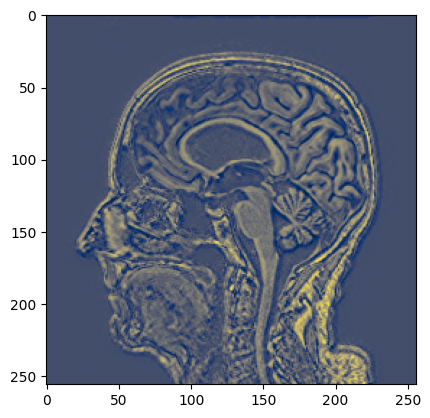

In [304]:
def edge_detection(image):
    edge_x = np.clip(image-np.roll(image,3,axis=0),-100,100)
    edge_y = np.clip(image-np.roll(image,3,axis=1),-100,100)
    edge_z = np.clip(image-np.roll(image,3,axis=2),-100,100)
    return image + (edge_x + edge_y + edge_z)

plt.imshow(edge_detection(images[3])[:,:,85], cmap='cividis')

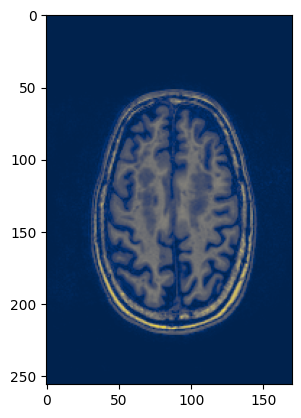

In [ ]:
# Could de-skull by starting from the top and removing the first layer we find, and from there 3d fill to the next layer avoiding
# the empty layer between brain and skull?
plt.imshow((images[3])[70,:,:], cmap='cividis')

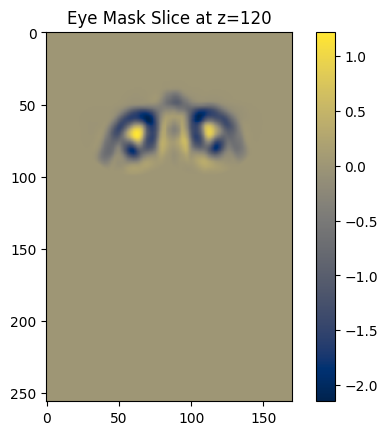

In [436]:
from scipy.ndimage import uniform_filter

def eye_detector(image, z, y, x):
    
    # Compute distances from (x=60) and (x=128-60)
    x_dist = np.minimum(np.abs(x - 60), np.abs(x - (170 - 60)))
    
    # Compute distances from (y=60) and (z=120)
    y_dist = np.abs(y - 60)
    z_dist = np.abs(z - 130)
    
    # Compute the eye detection score
    score= np.clip(1500 - x_dist**2 - y_dist**2 + z_dist**2, 0, 1e+10)
    # Local density (average over a radius of 10)
    local_avg = uniform_filter(image, size=10)
    local_avg1 = uniform_filter(np.roll(image,shift=10,axis=1), size=23)
    return score*(-local_avg+local_avg1)/90000 # - np.roll(local_avg,shift=15,axis=1)

# Assuming `images[3]` is already loaded as a NumPy array
image = images[3]

# Initialize an empty eye mask
eye_mask = np.zeros_like(image)

# Get the dimensions of the image
x_dim, y_dim, z_dim = eye_mask.shape

# Create a grid of x, y, and z coordinates
x, y, z = np.meshgrid(
    np.arange(x_dim), np.arange(y_dim), np.arange(z_dim), indexing='ij'
)

# Apply the updated eye detector function in a vectorized manner
eye_mask = eye_detector(image, x, y, z)

# Visualize the result for x=120
plt.imshow(eye_mask[120, :, :], cmap='cividis')
plt.colorbar()
plt.title("Eye Mask Slice at z=120")
plt.show()


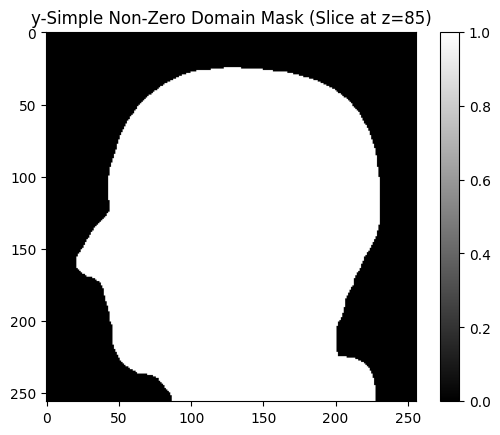

Mesh saved as output_mesh.stl


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from skimage.measure import marching_cubes, mesh_surface_area
from stl import mesh

# Assuming `images` is a 4D numpy array and we are processing images[3]
image = uniform_filter(images[3], size=10)
mask = np.zeros_like(image, dtype=np.uint8)

# Iterate over the x and z dimensions
for x in range(image.shape[0]):
    for z in range(image.shape[2]):
        # Find the non-zero y indices for the current (x, z) plane
        y_indices = np.where(image[x, :, z] > 40)[0]

        if y_indices.size > 4:
            # Get the first and last non-zero indices
            y_start, y_end = y_indices[2], y_indices[-2]

            # Fill the mask with 1's within this range
            mask[x, y_start:y_end + 1, z] = 1

# Visualize the result for a slice
plt.imshow(mask[:, :, 85], cmap='gray')
plt.colorbar()
plt.title("y-Simple Non-Zero Domain Mask (Slice at z=85)")
plt.show()

# Generate the mesh using marching cubes
verts, faces, normals, values = marching_cubes(mask, level=0.5)

# Save the mesh as an STL file
output_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        output_mesh.vectors[i][j] = verts[f[j], :]

# Save to file
output_mesh.save("output_mesh.stl")
print("Mesh saved as output_mesh.stl")


In [ ]:
# https://arxiv.org/pdf/2204.05778
# used adam with lr=1e-3, batch_size=32
print(0.97*(1-0.285) / (0.03*(1-0.778))) # thresh loss remove sample = 1.3*mean loss of this epoch (each 5th epoch)
print(0.97*(1-0.175) / (0.03*(1-0.500))) # signal to noise ratio keeps going down after this...
print(0.97*(1-0.093) / (0.03*(1-0.508)))

104.13663663663667
53.349999999999994
59.60636856368564
49.47899618112385


Downsampled shape: (51, 51, 34)
Optimizing alignment for scan 1/25...
Optimizing alignment for scan 2/25...
Optimizing alignment for scan 3/25...
Optimizing alignment for scan 5/25...
Optimizing alignment for scan 6/25...
Optimizing alignment for scan 7/25...
Optimizing alignment for scan 8/25...
Optimizing alignment for scan 9/25...
Optimizing alignment for scan 10/25...
Optimizing alignment for scan 11/25...
Optimizing alignment for scan 12/25...
Optimizing alignment for scan 13/25...
Optimizing alignment for scan 14/25...
Optimizing alignment for scan 15/25...
Optimizing alignment for scan 16/25...
Optimizing alignment for scan 17/25...
Optimizing alignment for scan 18/25...
Optimizing alignment for scan 19/25...
Optimizing alignment for scan 20/25...
Optimizing alignment for scan 21/25...
Optimizing alignment for scan 22/25...
Optimizing alignment for scan 23/25...
Optimizing alignment for scan 24/25...
Optimizing alignment for scan 25/25...
Applying transformation to full-resoluti

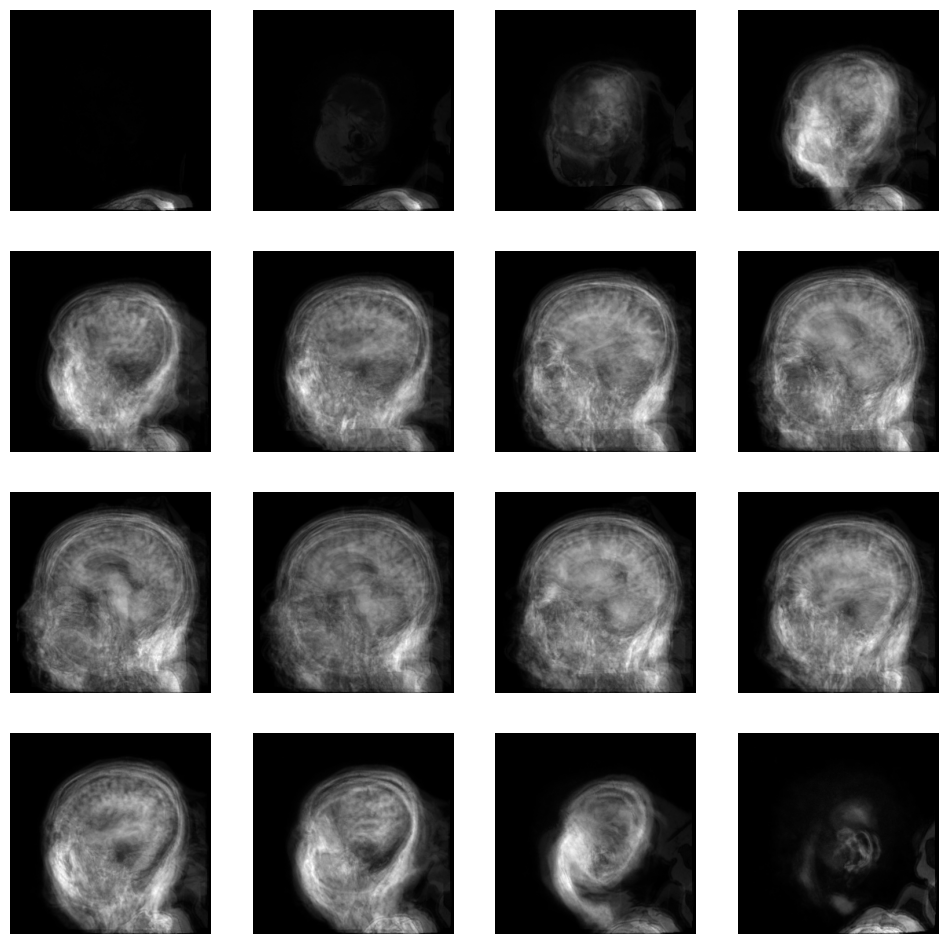

In [293]:
import scipy.optimize
from scipy.ndimage import affine_transform, zoom

# Parameters
downsample_factor = 0.2  # Adjust as needed for faster processing
reference_index = 3

# Downsample images
def downsample(img, factor):
    return zoom(img, factor, order=1)  # Linear interpolation for downsampling

def check_and_correct_rotation(img):
    """
    Check the brightness along edges and rotate the image if necessary.
    :param img: 3D numpy array (image data)
    :return: Corrected image
    """
    # Calculate mean brightness along edges
    bottom_edge_brightness = np.mean(img[-1, :, :])  # Bottom edge along z-axis
    right_edge_brightness = np.mean(img[:, -1, :])  # Right edge along y-axis
    
    # Determine if rotation is needed
    if right_edge_brightness > bottom_edge_brightness:
        #print("Rotating image 180 degrees about the xy-diagonal.")
        # Rotate about the xy-diagonal
        img = np.transpose(img, axes=(1, 0, 2))  # Swap x and y axes
        img = img[:, :, ::-1]  # Reverse the swapped axis
    return img

# Apply rotation correction to all images
corrected_images = []
for i, img in enumerate(images):
    #print(f"Checking and correcting rotation for image {i+1}/{len(images)}...")
    corrected_img = check_and_correct_rotation(img)
    corrected_images.append(corrected_img)

# Downsample corrected images for alignment
downsampled_images = [downsample(edge_detection(img), downsample_factor) for img in corrected_images]

print(f"Downsampled shape: {downsampled_images[0].shape}")

# Reference scan (downsampled)
reference_scan = downsampled_images[reference_index]

# Transformation function
def transform_image(img, params, full_shape=None):
    tx, ty, tz, rx, ry, rz, scale = params
    Rx = np.array([[1, 0, 0], [0, np.cos(rx), -np.sin(rx)], [0, np.sin(rx), np.cos(rx)]])
    Ry = np.array([[np.cos(ry), 0, np.sin(ry)], [0, 1, 0], [-np.sin(ry), 0, np.cos(ry)]])
    Rz = np.array([[np.cos(rz), -np.sin(rz), 0], [np.sin(rz), np.cos(rz), 0], [0, 0, 1]])
    R = Rx @ Ry @ Rz
    scaling_matrix = np.eye(3) * scale
    transformation_matrix = R @ scaling_matrix
    transformed_img = affine_transform(img, transformation_matrix, offset=(tx, ty, tz), order=1)
    if full_shape:
        transformed_img = zoom(transformed_img, [fs / ds for fs, ds in zip(full_shape, img.shape)], order=1)
    return transformed_img

# Loss function
def loss_function(params, moving_img, reference_img):
    transformed_img = transform_image(moving_img, params)
    return np.mean((transformed_img - reference_img)**2) #  Should maybe use edge detection instead?!

# Optimize alignment
aligned_images_downsampled = []
transform_params = []

for i, img in enumerate(downsampled_images):
    if i == reference_index:  # Skip reference
        aligned_images_downsampled.append(img)
        transform_params.append(None)  # No transformation for reference
        continue
    
    print(f"Optimizing alignment for scan {i+1}/{len(images)}...")
    initial_params = [0, 0, 0, 0, 0, 0, 1]  # Initial guess
    result = scipy.optimize.minimize(
        loss_function, 
        initial_params, 
        args=(img, reference_scan), 
        method='Powell'
    )
    optimal_params = result.x
    transform_params.append(optimal_params)
    aligned_img = transform_image(img, optimal_params)
    aligned_images_downsampled.append(aligned_img)

# Apply transformations to full-resolution images
aligned_images_full = []
for i, img in enumerate(images):
    if i == reference_index:  # Skip reference
        aligned_images_full.append(img)
        continue
    print(f"Applying transformation to full-resolution scan {i+1}/{len(images)}...")
    aligned_img = transform_image(img, transform_params[i], full_shape=img.shape)
    aligned_images_full.append(aligned_img)

# Calculate the mean brain
mean_brain = np.mean(aligned_images_full, axis=0)

# Visualize the mean brain
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.reshape(-1)):
    slice_index = i * int(mean_brain.shape[2] / 16)
    ax.imshow(mean_brain[:, :, slice_index], cmap='gray')
    ax.axis('off')

plt.show()


Downsampled shape: (51, 51, 34)
Optimizing alignment for scan 1/25...
Optimizing alignment for scan 2/25...
Optimizing alignment for scan 3/25...
Optimizing alignment for scan 5/25...
Optimizing alignment for scan 6/25...
Optimizing alignment for scan 7/25...
Optimizing alignment for scan 8/25...
Optimizing alignment for scan 9/25...
Optimizing alignment for scan 10/25...
Optimizing alignment for scan 11/25...
Optimizing alignment for scan 12/25...
Optimizing alignment for scan 13/25...
Optimizing alignment for scan 14/25...
Optimizing alignment for scan 15/25...
Optimizing alignment for scan 16/25...
Optimizing alignment for scan 17/25...
Optimizing alignment for scan 18/25...
Optimizing alignment for scan 19/25...
Optimizing alignment for scan 20/25...
Optimizing alignment for scan 21/25...
Optimizing alignment for scan 22/25...
Optimizing alignment for scan 23/25...
Optimizing alignment for scan 24/25...
Optimizing alignment for scan 25/25...
Applying transformation to full-resoluti

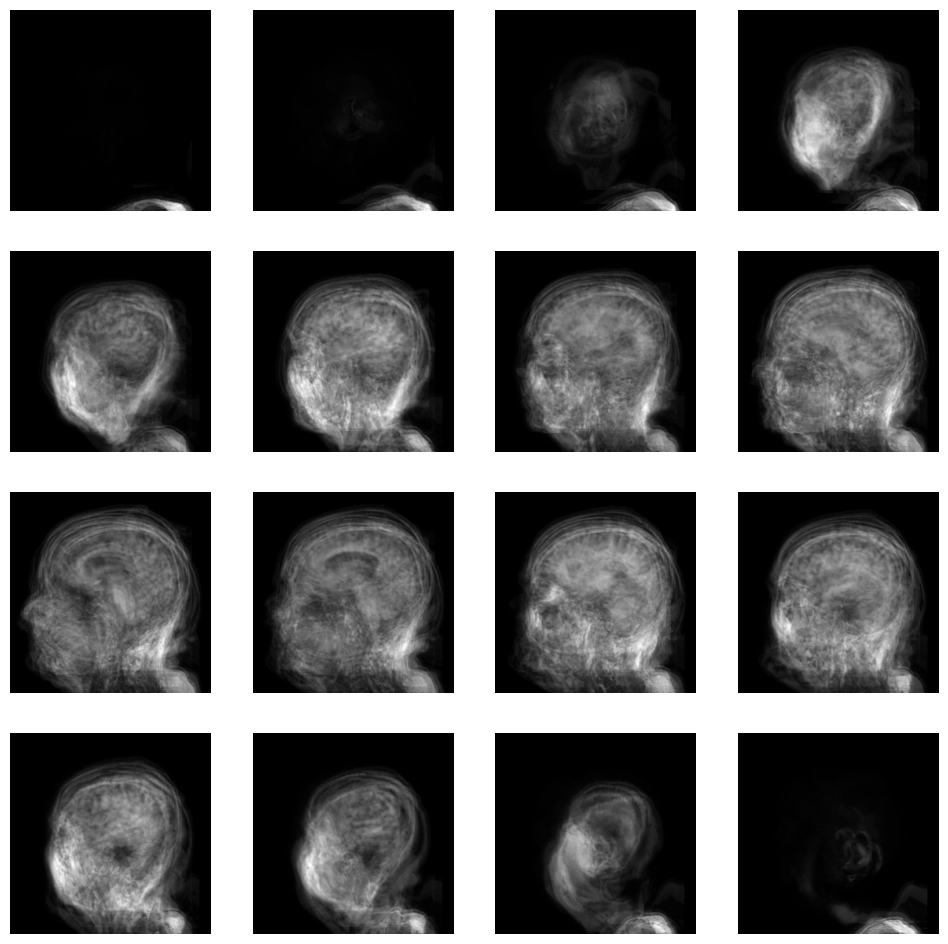

In [124]:
import scipy.optimize
from scipy.ndimage import affine_transform, zoom

# Parameters
downsample_factor = 0.2  # Adjust as needed for faster processing
reference_index = 3

# Downsample images
def downsample(img, factor):
    return zoom(img, factor, order=1)  # Linear interpolation for downsampling

downsampled_images = [downsample(img, downsample_factor) for img in images]
print(f"Downsampled shape: {downsampled_images[0].shape}")

# Reference scan (downsampled)
reference_scan = downsampled_images[reference_index]

# Transformation function
def transform_image(img, params, full_shape=None):
    tx, ty, tz, rx, ry, rz, scale = params
    Rx = np.array([[1, 0, 0], [0, np.cos(rx), -np.sin(rx)], [0, np.sin(rx), np.cos(rx)]])
    Ry = np.array([[np.cos(ry), 0, np.sin(ry)], [0, 1, 0], [-np.sin(ry), 0, np.cos(ry)]])
    Rz = np.array([[np.cos(rz), -np.sin(rz), 0], [np.sin(rz), np.cos(rz), 0], [0, 0, 1]])
    R = Rx @ Ry @ Rz
    scaling_matrix = np.eye(3) * scale
    transformation_matrix = R @ scaling_matrix
    transformed_img = affine_transform(img, transformation_matrix, offset=(tx, ty, tz), order=1)
    if full_shape:
        transformed_img = zoom(transformed_img, [fs / ds for fs, ds in zip(full_shape, img.shape)], order=1)
    return transformed_img

# Loss function
def loss_function(params, moving_img, reference_img):
    transformed_img = transform_image(moving_img, params)
    return np.mean((transformed_img[:,:,::5] - reference_img[:,:,::5])**2)

# Optimize alignment
aligned_images_downsampled = []
transform_params = []

for i, img in enumerate(downsampled_images):
    if i == reference_index:  # Skip reference
        aligned_images_downsampled.append(img)
        transform_params.append(None)  # No transformation for reference
        continue
    
    print(f"Optimizing alignment for scan {i+1}/{len(images)}...")
    initial_params = [0, 0, 0, 0, 0, 0, 1]  # Initial guess
    result = scipy.optimize.minimize(
        loss_function, 
        initial_params, 
        args=(img, reference_scan), 
        method='Powell'
    )
    optimal_params = result.x
    transform_params.append(optimal_params)
    aligned_img = transform_image(img, optimal_params)
    aligned_images_downsampled.append(aligned_img)

# Apply transformations to full-resolution images
aligned_images_full = []
for i, img in enumerate(images):
    if i == reference_index:  # Skip reference
        aligned_images_full.append(img)
        continue
    print(f"Applying transformation to full-resolution scan {i+1}/{len(images)}...")
    aligned_img = transform_image(img, transform_params[i], full_shape=img.shape)
    aligned_images_full.append(aligned_img)

# Calculate the mean brain
mean_brain = np.mean(aligned_images_full, axis=0)

# Visualize the mean brain
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.reshape(-1)):
    slice_index = i * int(mean_brain.shape[2] / 16)
    ax.imshow(mean_brain[:, :, slice_index], cmap='gray')
    ax.axis('off')

plt.show()

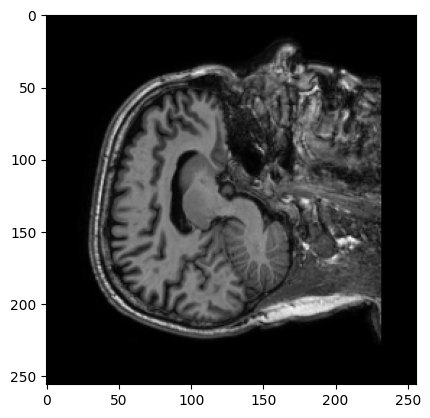

In [125]:
plt.imshow(aligned_images_full[13][:,:,85], cmap='gray')
#plt.imshow(transform_image(images[3],[40,0,0,0,0,-0.3,1])[:,:,85], cmap='gray')

In [ ]:
# Define the autoencoder architecture
def create_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)

    # Latent space
    encoded = layers.Flatten()(x)
    encoded = layers.Dense(128, activation='relu')(encoded)

    # Decoder
    x = layers.Dense(np.prod(input_shape) // 8, activation='relu')(encoded)
    x = layers.Reshape((input_shape[0] // 4, input_shape[1] // 4, input_shape[2] // 4, 16))(x)
    x = layers.Conv3DTranspose(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3DTranspose(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)

    # Output layer
    decoded = layers.Conv3DTranspose(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder

# Create the autoencoder
input_shape = (img.shape[0], img.shape[1], img.shape[2], 1)  # Adding a channel dimension
autoencoder = create_autoencoder(input_shape)

# Summary of the autoencoder model
autoencoder.summary()
